# Initial Setup

In [2]:
from google.colab import drive
drive.mount('/gdrive')
!ls /gdrive

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive
'My Drive'  'Shared drives'


In [3]:
import os

BASE_PATH = '/gdrive/Shared drives/CSE599G1 Deep Learning Project/'
STYLE_PATH = BASE_PATH + 'images'
os.chdir(STYLE_PATH)
!ls
os.chdir(BASE_PATH)

input  output  style


In [4]:
import torch
print('Version', torch.__version__)
print('CUDA enabled:', torch.cuda.is_available())

Version 1.3.1
CUDA enabled: True


In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [0]:
# Download pretrained VGG19 Model
if "vgg19-d01eb7cb.pth" not in os.listdir(BASE_PATH+"models/"):
    !wget -c https://s3-us-west-2.amazonaws.com/jcjohns-models/vgg19-d01eb7cb.pth
    !cp vgg19-d01eb7cb.pth models/

In [0]:
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, models
import torch.optim as optim

from os.path import isfile, join
from copy import deepcopy
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Define ArtNet

In [0]:
class ArtNet(nn.Module):
    def __init__(self):
        super(ArtNet, self).__init__()
        # use feature layers from VGG19
        model = models.vgg19(pretrained=True)
        model.load_state_dict(torch.load(MODEL_PATH), strict=False)
        self.artnet = deepcopy(model.features)
        # replace max pooling with avg pooling
        for idx, layer in self.artnet.named_children():
            if isinstance(layer, nn.MaxPool2d):
                self.artnet[int(idx)] = nn.AvgPool2d(kernel_size=2, stride=2)
        # lock gradient
        for param in self.artnet.parameters():
            param.requires_grad=False

    def get_features(self, x):
        features = {}
        layers = {
            '3': 'relu1_2',
            '8': 'relu2_2',
            '17' : 'relu3_3',
            '26' : 'relu4_3',
            '35' : 'relu5_3',
            '22' : 'relu4_2'
        }
        for idx, layer in self.artnet.named_children():
            x = layer(x)
            if idx in layers:
                if idx == '22':
                    features[layers[idx]] = x
                else:
                    B, C, H, W = x.shape
                    features[layers[idx]] = gram(x) / (H * W)
            if idx == '35':
                break
        return features

# Load Input Image and Style Image

In [0]:
# load image from given path
def load_image(image_path):
    return cv2.imread(image_path)

# show image
def show_image(image, title=None):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = np.array(image/255).clip(0,1)
    plt.figure()
    plt.imshow(image)
    if title != None:
        plt.title(title)

# convert image to tensor
def image_to_tensor(image):
    H, W, C = image.shape
    image_size = tuple([int((float(1024) / max([H,W])) * x) for x in [H, W]])
    transformer = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(image_size),
        transforms.ToTensor()
    ])
    normalizer = transforms.Normalize([103.939, 116.779, 123.68],[1,1,1])
    tensor = normalizer(transformer(image)*255)
    tensor = tensor.unsqueeze(dim=0)
    return tensor

# convert tensor to image
def tensor_to_image(tensor):
    tensor = tensor.squeeze()
    transformer = transforms.Normalize([-103.939, -116.779, -123.68],[1,1,1])
    image = transformer(tensor)
    image = image.cpu().numpy().transpose(1, 2, 0) # C, H, W -> H, W, C
    return image

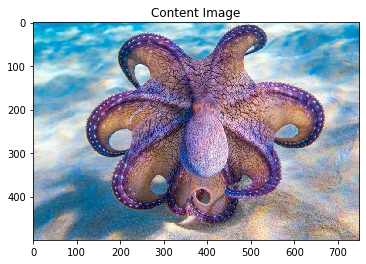

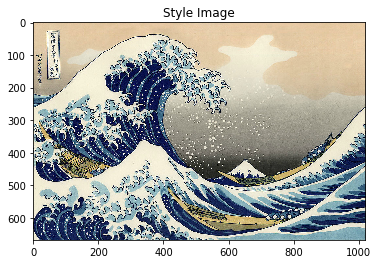

In [10]:
CONTENT_PATH = "./images/input/octopus4.jpg"
STYLE_PATH =  "./images/style/Hokusai - The Great Wave off Kanagawa.jpg"
MODEL_PATH = "./models/vgg19-d01eb7cb.pth"
OPTIMIZER = "adam" # "lbfgs"
MAX_ITER = 300
CONTENT_WEIGHT = 1
STYLE_WEIGHT = 100
TV_WEIGHT = 0.01
PRESERVE_COLOR = False
PIXEL_CLIP = True

content_image = load_image(CONTENT_PATH)
style_image = load_image(STYLE_PATH)
show_image(content_image, title="Content Image")
show_image(style_image, title="Style Image")
content_tensor = image_to_tensor(content_image).to(device)
style_tensor = image_to_tensor(style_image).to(device)

# Define Loss Functions

In [0]:
# content loss
def content_loss(output_features, content_features):
    loss = F.mse_loss(output_features, content_features)
    return loss

# gram matrix
def gram(tensor):
    B, C, H, W = tensor.shape
    x = tensor.view(C, H*W)
    return torch.mm(x, x.t())

# style loss
def style_loss(output_features, style_feature):
    C1, C2 = output_features.shape
    loss = F.mse_loss(output_features, style_feature)
    loss /= C1 ** 2
    return loss

# total variation loss
def tv_loss(content_features):
    x = content_features[:,:,1:,:] - content_features[:,:,:-1,:]
    y = content_features[:,:,:,1:] - content_features[:,:,:,:-1]
    loss = torch.sum(torch.abs(x)) + torch.sum(torch.abs(y))
    return loss

# Style Transfer

In [0]:
class StyleTransfer():
    def __init__(self, content_image, style_image):
        self.content = content_image
        self.style = style_image
        self.output = content_image.clone().detach().to(device).requires_grad_(True)
        self.best = deepcopy(self.output)
        self.total_loss = 10e10

    def get_optimizer(self, option):
        if option == "lbfgs":
            opt = optim.LBFGS([self.output])
        elif option == "adam":
            opt = optim.Adam([self.output], lr=10)
        return opt

    def preserve_color(self):
        content = tensor_to_image(self.content.clone().detach())
        output = tensor_to_image(self.output.clone().detach())
        if PIXEL_CLIP:
            content = content.clip(0,255)
            output = output.clip(0,255)   
        H, W, _ = content.shape
        output = cv2.resize(output, dsize=(W, H), interpolation=cv2.INTER_CUBIC)
        output_gray = cv2.cvtColor(output, cv2.COLOR_BGR2GRAY) # extract the luminance of output image
        content_ = cv2.cvtColor(content, cv2.COLOR_BGR2YCrCb) # convert content image from BGR to YIQ/YCbCr
        content_[...,0] = output_gray # combine luminance and IQ/CbCr
        
        return cv2.cvtColor(content_, cv2.COLOR_YCrCb2BGR)

    def save_best_image(self, loss):
        # save best image with lowest total loss
        if loss < self.total_loss:
            self.total_loss = loss
            if PRESERVE_COLOR:
                self.best = self.preserve_color()
            else:
                self.best = tensor_to_image(self.output.clone().detach())
        return

    def save_image(self):
        # save self.best as best image in output folder
        style = STYLE_PATH.split("/")[-1].rstrip(".jpg") # style image name
        image_name = CONTENT_PATH.split("/")[-1].rstrip(".jpg") # content image name
        save_path = "./images/output/"+style+"-"+image_name
        if PRESERVE_COLOR:
            save_path += "-color" # preserve color version
        save_path += ".jpg"
        if PIXEL_CLIP:
            self.best = self.best.clip(0, 255)
        cv2.imwrite(save_path, self.best)
        return

    def transfer_style(self):
        content_layers = ['relu4_2']
        content_weights = {'relu4_2': 1.0} 
        style_layers = ['relu1_2', 'relu2_2', 'relu3_3', 'relu4_3', 'relu5_3']
        style_weights = {'relu1_2': 0.2, 'relu2_2': 0.2, 'relu3_3': 0.2, 'relu4_3': 0.2, 'relu5_3': 0.2}
        model = ArtNet().to(device)
        content_features = model.get_features(self.content)
        style_features = model.get_features(self.style)
        optimizer = self.get_optimizer(OPTIMIZER)
        i = [0]
        while i[0] < MAX_ITER:
            def closure():
                output_features = model.get_features(self.output)
                optimizer.zero_grad()
                c_loss = 0
                s_loss = 0
                for j in content_layers:
                    c_loss += content_weights[j] * content_loss(output_features[j], content_features[j])
                for j in style_layers:
                    s_loss += style_weights[j] * style_loss(output_features[j], style_features[j])
                c_loss = CONTENT_WEIGHT * c_loss
                s_loss = STYLE_WEIGHT * s_loss
                t_loss = TV_WEIGHT * tv_loss(self.output.clone().detach())
                total_loss = c_loss + s_loss + t_loss
                total_loss.backward(retain_graph=True)
                self.save_best_image(total_loss) # save best image

                i[0] += 1
                return total_loss
            
            optimizer.step(closure)
        
        self.save_image()
        show_image(self.best)
        plt.show()
        return

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:23<00:00, 24.4MB/s]


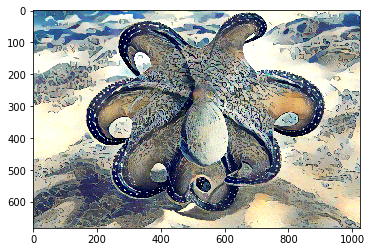

In [13]:
PRESERVE_COLOR = False

myStyleTransfer = StyleTransfer(content_tensor, style_tensor)
myStyleTransfer.transfer_style()

# Multi-Style Transfer

In [0]:
class MultiStyleTransfer():
    def __init__(self, content_image, style_images, style_blend_weights):
        self.content = content_image
        self.styles = style_images
        self.style_blend_weights = style_blend_weights
        self.output = content_image.clone().detach().to(device).requires_grad_(True)
        self.best = deepcopy(self.output)
        self.total_loss = 10e10

    def get_optimizer(self, option):
        if option == "lbfgs":
            opt = optim.LBFGS([self.output])
        elif option == "adam":
            opt = optim.Adam([self.output], lr=10)
        return opt

    def preserve_color(self):
        content = tensor_to_image(self.content.clone().detach())
        output = tensor_to_image(self.output.clone().detach())
        if PIXEL_CLIP:
            content = content.clip(0,255)
            output = output.clip(0,255)   
        H, W, _ = content.shape
        output = cv2.resize(output, dsize=(W, H), interpolation=cv2.INTER_CUBIC)
        output_gray = cv2.cvtColor(output, cv2.COLOR_BGR2GRAY) # extract the luminance of output image
        content_ = cv2.cvtColor(content, cv2.COLOR_BGR2YCrCb) # convert content image from BGR to YIQ/YCbCr
        content_[...,0] = output_gray # combine luminance and IQ/CbCr
        
        return cv2.cvtColor(content_, cv2.COLOR_YCrCb2BGR)

    def save_best_image(self, loss):
        # save best image with lowest total loss
        if loss < self.total_loss:
            self.total_loss = loss
            if PRESERVE_COLOR:
                self.best = self.preserve_color()
            else:
                self.best = tensor_to_image(self.output.clone().detach())
        return

    # def save_image(self):
    #     # save self.best as best image in output folder
    #     style = MULTI_STYLE_PATH.split("/")[-2] # style name
    #     image_name = CONTENT_PATH.split("/")[-1].rstrip(".jpg") # content image name
    #     wt = 
    #     save_path = "./images/output/"+style+"-"+image_name
    #     if PRESERVE_COLOR:
    #         save_path += "-color" # preserve color version
    #     save_path += ".jpg"
    #     if PIXEL_CLIP:
    #         self.best = self.best.clip(0, 255)
    #     cv2.imwrite(save_path, self.best)
    #     return
      
    def save_image(self):
        # save self.best as best image in output folder
        style = MULTI_STYLE_PATH.split("/")[-2] # style name
        image_name = CONTENT_PATH.split("/")[-1].rstrip(".jpg") # content image name
        save_path = "./images/output/Hokusai + Qi Baishi-"+''.join([str(int(s*100)) for s in self.style_blend_weights])+"-"+image_name
        if PRESERVE_COLOR:
            save_path += "-color" # preserve color version
        save_path += ".jpg"
        if PIXEL_CLIP:
            self.best = self.best.clip(0, 255)
        cv2.imwrite(save_path, self.best)
        return

    def transfer_style(self):
        content_layers = ['relu4_2']
        content_weights = {'relu4_2': 1.0} 
        style_layers = ['relu1_2', 'relu2_2', 'relu3_3', 'relu4_3', 'relu5_3']
        style_weights = {'relu1_2': 0.2, 'relu2_2': 0.2, 'relu3_3': 0.2, 'relu4_3': 0.2, 'relu5_3': 0.2}
        model = ArtNet().to(device)
        content_features = model.get_features(self.content)
        style_features_list = [model.get_features(s.to(device)) for s in self.styles]        
        optimizer = self.get_optimizer(OPTIMIZER)
        i = [0]
        while i[0] < MAX_ITER:
            def closure():
                output_features = model.get_features(self.output)
                optimizer.zero_grad()
                c_loss = 0
                s_loss = 0
                for j in content_layers:
                    c_loss += content_weights[j] * content_loss(output_features[j], content_features[j])
                for k, s in enumerate(style_features_list):
                    for j in style_layers:
                      s_loss += self.style_blend_weights[k]*(style_weights[j] * style_loss(output_features[j], s[j]))
                c_loss = CONTENT_WEIGHT * c_loss
                s_loss = STYLE_WEIGHT * s_loss
                t_loss = TV_WEIGHT * tv_loss(self.output.clone().detach())
                total_loss = c_loss + s_loss + t_loss
                total_loss.backward(retain_graph=True)
                self.save_best_image(total_loss) # save best image

                i[0] += 1
                return total_loss
            
            optimizer.step(closure)
        
        self.save_image()
        show_image(self.best)
        plt.show()
        return

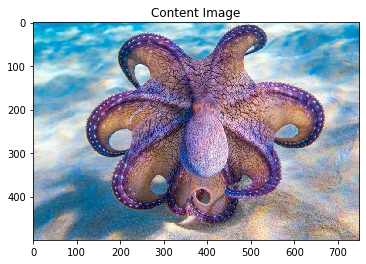

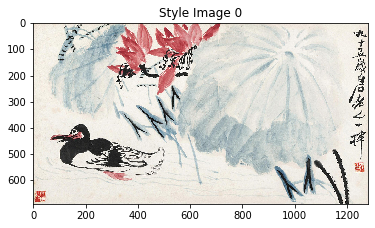

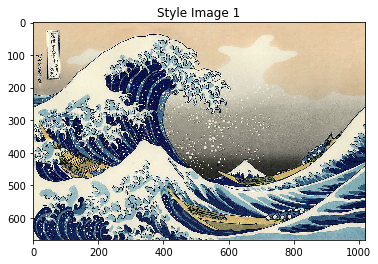

In [21]:
CONTENT_PATH = "./images/input/octopus4.jpg"
MULTI_STYLE_PATH =  "./images/style/multi1/"
MODEL_PATH = "./models/vgg19-d01eb7cb.pth"
OPTIMIZER = "adam" # "lbfgs"
MAX_ITER = 300
CONTENT_WEIGHT = 1
STYLE_WEIGHT = 100
TV_WEIGHT = 0.01
PRESERVE_COLOR = False
PIXEL_CLIP = True

content_image = load_image(CONTENT_PATH)

num_styles = len(os.listdir(MULTI_STYLE_PATH))
STYLE_BLEND_WEIGHT = [1/num_styles for n in range(num_styles)] #default is evenly weighted across all styles

show_image(content_image, title="Content Image")
style_image_list = [load_image(MULTI_STYLE_PATH + f) for f in os.listdir(MULTI_STYLE_PATH)]
for i, s in enumerate(style_image_list):
  show_image(s, title="Style Image "+str(i))

content_tensor = image_to_tensor(content_image).to(device)
style_tensor_list = [image_to_tensor(s) for s in style_image_list]

In [22]:
PRESERVE_COLOR = False
STYLE_BLEND_WEIGHT = [0.5, 0.5] #overwrite using custom weight

list_of_wts = [[0.1, 0.9], [0.5, 0.5], [0.9, 0.1]]
list_of_imgs = [
  "./images/input/grumpy-cat.jpg",
  "./images/input/paris.jpg",
  "./images/input/seattle.jpg",
  "./images/input/uw-cherry.jpg",
  "./images/input/wave.jpg"
]

for c in list_of_imgs:
  print(c)
  CONTENT_PATH = c
  content_image = load_image(c)
  content_tensor = image_to_tensor(content_image).to(device)
  for wt in list_of_wts:
    print(wt)
    myMultiStyleTransfer = MultiStyleTransfer(content_tensor, style_tensor_list, wt)
    myMultiStyleTransfer.transfer_style()



Output hidden; open in https://colab.research.google.com to view.

# Testing

In [0]:
#Testing
os.chdir('/gdrive/Shared drives/CSE599G1 Deep Learning Project/')
content_name = [f for f in os.listdir("./images/input/") if isfile(join("./images/input/", f))]
style_name = [f for f in os.listdir("./images/style/") if isfile(join("./images/style/", f))]
print(content_name)
print(style_name)

['uw-cherry.jpg', 'grumpy-cat.jpg', 'paris.jpg', 'wave.jpg']
['Monet - Camille Monet On Her Deathbed.jpg', 'Picasso - The Dream.jpg', 'Rousseau - Myself.jpg', 'van Gogh - Starry Night.jpg', 'Gao Jianfu - Cotton Roses and Mandarin Ducks.jpg', 'Qi Baishi - Lotus Flowers and Wild Duck.jpg', 'Hokusai - The Great Wave off Kanagawa.jpg', 'Aoyama - Detective Conan.jpg']


In [0]:
# read current total loss

total_loss_dict = {}
f = open("./total_loss.csv", "r")
for line in f:
    key, total_loss = line.split(",")
    total_loss_dict[key] = float(total_loss)
f.close()

In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_PATH = "./models/vgg19-d01eb7cb.pth"
OPTIMIZER = "adam" # "lbfgs"
MAX_ITER = 300
CONTENT_WEIGHT = 1
STYLE_WEIGHT = 1000
TV_WEIGHT = 0.001
PIXEL_CLIP = True

for i in content_name:
  for j in style_name:
    CONTENT_PATH = "./images/input/" + i
    STYLE_PATH =  "./images/style/" + j
    file_name =  STYLE_PATH.split("/")[-1].rstrip(".jpg") + '-' + CONTENT_PATH.split("/")[-1].rstrip(".jpg")
    if file_name not in total_loss_dict:
        print("Generating output images", file_name + "...")
        content_image = load_image(CONTENT_PATH)
        style_image = load_image(STYLE_PATH)
        content_tensor = image_to_tensor(content_image).to(device)
        style_tensor = image_to_tensor(style_image).to(device)

        # not preserve color
        PRESERVE_COLOR = False
        myStyleTransfer = StyleTransfer(content_tensor, style_tensor)
        myStyleTransfer.transfer_style()  
        total_loss_dict[file_name] = myStyleTransfer.total_loss.cpu().detach()
        
        # preserve color
        PRESERVE_COLOR = True
        myStyleTransfer = StyleTransfer(content_tensor, style_tensor)
        myStyleTransfer.transfer_style()
        total_loss_dict[file_name+'-color'] = myStyleTransfer.total_loss.cpu().detach()

In [0]:
f = open("./total_loss.csv", "w")
for key, total_loss in total_loss_dict.items():
    f.write(key + "," + str(float(total_loss)) + "\n")
f.close()

In [0]:
!cat ./total_loss.csv

Monet - Camille Monet On Her Deathbed-uw-cherry,77290.953125
Monet - Camille Monet On Her Deathbed-uw-cherry-color,77290.953125
Picasso - The Dream-uw-cherry,167316.78125
Picasso - The Dream-uw-cherry-color,167316.78125
Rousseau - Myself-uw-cherry,95196.0078125
Rousseau - Myself-uw-cherry-color,95196.0078125
van Gogh - Starry Night-uw-cherry,110918.3046875
van Gogh - Starry Night-uw-cherry-color,110918.3046875
Gao Jianfu - Cotton Roses and Mandarin Ducks-uw-cherry,130667.21875
Gao Jianfu - Cotton Roses and Mandarin Ducks-uw-cherry-color,130667.21875
Qi Baishi - Lotus Flowers and Wild Duck-uw-cherry,152211.046875
Qi Baishi - Lotus Flowers and Wild Duck-uw-cherry-color,152211.046875
Hokusai - The Great Wave off Kanagawa-uw-cherry,159260.453125
Hokusai - The Great Wave off Kanagawa-uw-cherry-color,159260.453125
Aoyama - Detective Conan-uw-cherry,300087.8125
Aoyama - Detective Conan-uw-cherry-color,300087.8125
Monet - Camille Monet On Her Deathbed-grumpy-cat,89060.34375
Monet - Camille Mon